# Create dataset
***

**Autor:** Chus Casado Rodríguez<br>
**Fecha:** 03-09-2024<br>

**Introduction:**<br>
This code creates the time series for the reservoirs in ResOpsES. The time series include records from the Spanish Ministry of the Environment, Agència Catalana del'Aigua, Hidrosur, and simulations from EFAS.

The result is a time series that combines the observed data from the Spanish administrations with the simulation from EFASv5 (when possible). For each reservoir, these time series are exported both in CSV and a NetCDF format.

Records are cleaned to avoid errors:
    * Outliers in the **storage** time series are filtered by comparison with the a moving median (window 7 days). If the relative difference of a given storage value and the moving median exceeds a threshold, the value is removed. This procedure is encapsulated in the function `lisfloodreservoirs.utils.timeseries.clean_storage()`
    * Outliers in the **inflow** time series are removed using two conditions: one based in the gradient, and the other using an estimated inflow based on the water balance. When both conditions are met, the value is removed. Since inflow time series cannot contain missing values when used in the reservoir simulation, a simple linear interpolation is used to fill in gaps up to 7 days. This procedure is encapsulated in the function `lisfloodreservoirs.utils.timeseries.clean_inflow()`.

**To do:**<br>
* [x] Fix `point_polygon_statistics` to work with masks rasters instead of polygons, so that we can compute the attributes of reservoirs and lakes. <font color='steelblue'>I've done it using again `mask_statistics` but I needed to create a xr.DataArray of reservoir storage.
* [x] Would it be possible to use the new `lisflood-utilities.catchstats.catchment_statistics` function instead of `mask_statistics`?
* [x] In the [LISFLOOD parameters](#LISFLOOD-parameters), it could be interesting to extract the reservoir parameters for each of the reservoirs represented in EFAS. <font color='steelblue'> I have extracted for every reservoirs the calibrated reservoir parameters in their pixel</font>
* [x] There's 1 day lag between EFAS5 and EMO1. EMO1 starts January 2nd 1990, whereas EFAS5 January 1st. </font color='steelblue'>I substracted 30 hours from the original timestamp. For instance, the first timestamp is 1990-01-02 06:00 and refers to the period 1990-01-01 06:00 to 1990-01-02 06:00. By substracting 30 hours the timestamp becomes the start of the timestep and I have shifted 6 hours extra (approximation) to match the daily timestamps of the other data sources</font>
* [ ] The reservoir and lake attributes are at the moment computed from LISFLOOD maps, whereas in the case of reservoirs should be computed from the reservoirs included in the ResOpsES dataset.
* [x] Reservoir CEDEX=8012 has no data in the Hydro DB, even thouth it does have data in _Anuario de Aforos_. The reason is that the time series finishes before 1990.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
# import rioxarray
import geopandas as gpd
from shapely.geometry import mapping
from rasterio.features import shapes
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
import yaml
from collections import OrderedDict

In [2]:
from lisfloodreservoirs.utils import DatasetConfig
from lisfloodreservoirs import read_attributes
from lisfloodreservoirs.utils.plots import plot_resops, reservoir_analysis, compare_flows, plot_attributes
from lisfloodreservoirs.utils.timeseries import quantile_mapping #, clean_storage, clean_inflow 

In [3]:
import sys
sys.path.append('../../../lisflood-utilities/src')
from lisfloodutilities.catchstats import catchment_statistics

## Configuration

In [4]:
cfg = DatasetConfig('config_dataset.yml')

# paths to observed time series
PATH_DATASETS = Path('Z:/nahaUsers/casadje/datasets')
PATH_HDMS = PATH_DATASETS / 'hDMS' / 'reservoirs'
PATH_HIDROSUR = PATH_DATASETS / 'Hidrosur' / 'processed' / 'reservoirs'
PATH_ACA = PATH_DATASETS / 'ACA' / 'processed' / 'reservoirs'

print(f'Time series will be saved in {cfg.PATH_TS}')

Time series will be saved in Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsES\v3.0\time_series


## Selection of resevoirs

### Reservoirs

305 reservoirs and 13 attributes

filling key reservoir attributes
grand	CAP_MCM  	234 reservoirs added
grand	AREA_SKM 	234 reservoirs added

Reservoir attributes missing:
CAP_MCM     0
AREA_SKM    0
dtype: int64

234 reservoirs and 12 attributes


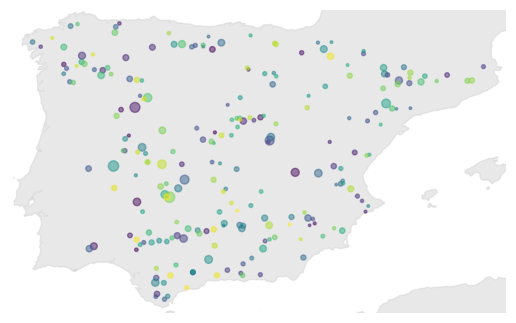

In [5]:
# load reservoir points
reservoirs = gpd.read_file(cfg.PATH_RESOPS / 'GIS' / 'reservoirs_ResOpsES.shp')
reservoirs[['LAT', 'LON', 'CAP_MCM', 'CATCH_SKM']] = reservoirs[['LAT', 'LON', 'CAP_MCM', 'CATCH_SKM']].astype(float)
# reservoirs['SNCZI'] = reservoirs['SNCZI'].astype(int)
print('{0} reservoirs and {1} attributes'.format(*reservoirs.shape))

# fill in key attributes
key_attributes = ['CAP_MCM', 'AREA_SKM']
reservoirs[key_attributes] = np.nan
sources = ['grand'] #['cedex', 'grand', 'icold']
attributes = {source.lower(): pd.read_csv(cfg.PATH_ATTRS / f'{source.lower()}.csv', index_col='GRAND_ID')[key_attributes + ['SNCZI']] for source in sources}

# set GRAND_ID as index to 'reservoirs'
map_snczi_grand = {snczi_id: grand_id for grand_id, snczi_id in attributes['grand'].SNCZI.iteritems()}
if 'GRAND_ID' not in reservoirs.columns:
    reservoirs['GRAND_ID'] = reservoirs.SNCZI.map(map_snczi_grand)
    reservoirs.loc[reservoirs.GRAND_ID.isnull(), 'GRAND_ID'] = -999
    reservoirs.GRAND_ID = reservoirs.GRAND_ID.astype(int)
    reservoirs.to_file(cfg.PATH_RESOPS / 'GIS' / 'reservoirs_ResOpsES.shp')
reservoirs = reservoirs[reservoirs.GRAND_ID != -999]
reservoirs.set_index('GRAND_ID', drop=True, inplace=True)

print('\nfilling key reservoir attributes')
for source, df in attributes.items():
    for col in key_attributes:
        # select reservoirs with missing data
        idx = df.index.intersection(reservoirs.loc[reservoirs[col].isnull()].index)
        df_ = df.loc[idx]
        # remove reservoirs in that soure missing data
        mask = df_[col].isnull()
        df__ = df_.loc[~mask]
        # attribute values
        if df__.shape[0] > 0:
            print(f'{source}\t{col:9}\t{df__.shape[0]} reservoirs added')
            reservoirs.loc[df__.index, col] = df__

print('\nReservoir attributes missing:')
mask = reservoirs[key_attributes].isnull()
print(mask.sum())
reservoirs = reservoirs.loc[~mask.any(axis=1)]

print('\n{0} reservoirs and {1} attributes'.format(*reservoirs.shape))

# plot reservoir locations
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
reservoirs.plot(markersize=reservoirs.CAP_MCM**.5, cmap='viridis', c=reservoirs.CATCH_SKM, alpha=.5, ax=ax)
ax.set_aspect('equal')
ax.axis('off');
plt.savefig('map_selected_reservoirs.jpg', dpi=300, bbox_inches='tight');

###  Catchments

In [6]:
path = cfg.PATH_RESOPS / 'ancillary' / 'cutmaps'
mask_map = 'upArea_01min.nc'

masks = {}
CATCH_SKM = {}
for snczi_id, grand_id in tqdm(map_snczi_grand.items(), desc='loading masks'):
    try:       
        # load upstream area map
        mask = xr.open_dataset(path / f'{snczi_id:04}' / mask_map)['Band1']
        mask.name = str(grand_id)

        # catchment area
        CATCH_SKM[grand_id] = mask.max().data
        
        # create and save a mask out of the previous map
        mask = xr.where(mask.notnull(), 1, mask)
        masks[grand_id] = mask
    except IOError as e:
        print("An I/O error occurred:", e)
        continue

# series of catchment area in km²
CATCH_SKM = pd.Series(CATCH_SKM, name='CATCH_SKM', dtype=float)
CATCH_SKM /= 1e6
idx = CATCH_SKM.index.intersection(reservoirs.index)
reservoirs.loc[idx, 'CATCH_SKM'] = CATCH_SKM.loc[idx]

# export masks as NetCDF with ID as filename to be used with `catchstats`
path_masks = cfg.PATH_RESOPS / 'ancillary' / 'cutmaps' / 'masks'
path_masks.mkdir(parents=True, exist_ok=True)
for ID, mask in masks.items():
    file_out = path_masks / f'{ID:04}.nc'
    if not file_out.exists():
        mask.to_netcdf(file_out)

loading masks:   0%|          | 0/253 [00:00<?, ?it/s]

An I/O error occurred: [Errno 2] No such file or directory: b'Z:\\nahaUsers\\casadje\\datasets\\reservoirs\\ResOpsES\\ancillary\\cutmaps\\0609\\upArea_01min.nc'
An I/O error occurred: [Errno 2] No such file or directory: b'Z:\\nahaUsers\\casadje\\datasets\\reservoirs\\ResOpsES\\ancillary\\cutmaps\\2075\\upArea_01min.nc'
An I/O error occurred: [Errno 2] No such file or directory: b'Z:\\nahaUsers\\casadje\\datasets\\reservoirs\\ResOpsES\\ancillary\\cutmaps\\1356\\upArea_01min.nc'
An I/O error occurred: [Errno 2] No such file or directory: b'Z:\\nahaUsers\\casadje\\datasets\\reservoirs\\ResOpsES\\ancillary\\cutmaps\\0848\\upArea_01min.nc'
An I/O error occurred: [Errno 2] No such file or directory: b'Z:\\nahaUsers\\casadje\\datasets\\reservoirs\\ResOpsES\\ancillary\\cutmaps\\2100\\upArea_01min.nc'
An I/O error occurred: [Errno 2] No such file or directory: b'Z:\\nahaUsers\\casadje\\datasets\\reservoirs\\ResOpsES\\ancillary\\cutmaps\\2098\\upArea_01min.nc'
An I/O error occurred: [Errno 2] N

## Time series

In this section I use the EMO1 meteorological time series and the EFAS5 discharge reanalysis to create both hydrometeorological attributes (_attributes_EFAS_hydrometeorology.csv_) and the time series that may be used as input in the deep learning model.

### Load time series
#### Meteorology: EMO-1

**Areal time series**

In [7]:
# load meteorological time series
path_meteo_areal = cfg.PATH_RESOPS / 'ancillary' / 'catchstats' / 'meteo'
variables = [x.stem for x in path_meteo_areal.iterdir() if x.is_dir()]
meteo_areal = xr.Dataset({f'{var}_emo1': xr.open_mfdataset(f'{path_meteo_areal}/{var}/*.nc')[f'{var}_mean'].compute() for var in variables})
meteo_areal['time'] = meteo_areal['time'] - np.timedelta64(30, 'h') # WARNING!! One day lag compared with EFAS5

# keep catchments in the attributes
IDs = list(set(map_snczi_grand).intersection(meteo_areal.id.data))
meteo_areal = meteo_areal.sel(id=IDs)

# rename 'id' with the GRanD ID
meteo_areal['id'] = [map_snczi_grand[ID] for ID in meteo_areal.id.data]
meteo_areal = meteo_areal.rename({'id': 'GRAND_ID'})

# define attributes
emo1_units = 'e0_emo1: potential evaporation from open water from EMO1 [mm/d]\npr_emo1: observed precipitation from EMO1 [mm/d]\nta_emo1: observed air temperature from EMO1 [°C]\n'
meteo_areal.attrs['Units'] = emo1_units
meteo_areal.time.attrs['timezone'] = 'UTC+00'
meteo_areal.GRAND_ID.attrs['Description'] = 'The identifier of the reservor in GRanD (Global Reservoir and Dam database)'

In [8]:
# # plot the time series of a specific catchment to check the areal aggregation
# fig, axes = plt.subplots(nrows=3, figsize=(12, 12), sharex=True)
# for ax, var in zip(axes, ['pr', 'ta', 'e0']):
#     meteo_areal[f'{var}_emo1'].isel(GRAND_ID=10).plot(ax=ax)

**Point time series**

In [9]:
# load meteorological time series
path_meteo_point = cfg.PATH_RESOPS / 'ancillary' / 'ncextract'
meteo_point = xr.Dataset({var: xr.open_mfdataset(f'{path_meteo_point}/{var}/*.nc', combine='nested', concat_dim='SNCZI')[var].compute() for var in ['e0', 'pr']})

# keep catchments in the attributes
IDs = list(set(map_snczi_grand).intersection(meteo_point.SNCZI.data))
meteo_point = meteo_point.sel(SNCZI=IDs)

# rename dimension as GRanD ID
meteo_point['SNCZI'] = [map_snczi_grand[ID] for ID in meteo_point.SNCZI.data]
meteo_point = meteo_point.rename({'SNCZI': 'GRAND_ID'})

# Create a CRS variable and set its attributes
crs_attrs = {'epsg_code': 'EPSG:4326',
             'semi_major_axis': 6378137.0,  # WGS 84
             'inverse_flattening': 298.257223563,  # WGS 84
             'grid_mapping_name': 'latitude_longitude'
            }
meteo_point['crs'] = xr.DataArray(data=0, attrs=crs_attrs)  # CRS variable with its attributes

# define attributes
meteo_point.attrs['Units'] = 'e01: open water evaporation (mm/d)\npr: precipitation (mm/d)'
meteo_point.time.attrs['timezone'] = 'UTC+00'
meteo_point.GRAND_ID.attrs['Description'] = 'The identifier of the reservor in GRanD (Global Reservoir and Dam database)'
lat_attrs = {'Units': 'degrees_north',
             'standard_name': 'latitude',
             'grid_mapping': 'crs'}
lon_attrs = {'Units': 'degrees_east',
             'standard_name': 'longitude',
             'grid_mapping': 'crs'}
meteo_point.lat.attrs = lat_attrs
meteo_point.lon.attrs = lon_attrs

#### Inflow: EFAS long run

In [10]:
# load discharge time series
path_discharge = cfg.PATH_RESOPS / 'ancillary' / 'ncextract' / 'dis'
inflow = xr.open_mfdataset(f'{path_discharge}/*.nc', combine='nested', concat_dim='SNCZI')['dis'].compute()
inflow.name = 'inflow' # inflow_efas5'

# keep catchments in the attributes
IDs = list(set(map_snczi_grand).intersection(inflow.SNCZI.data))
inflow = inflow.sel(SNCZI=IDs)

# rename dimension as GRanD ID
inflow['SNCZI'] = [map_snczi_grand[ID] for ID in inflow.SNCZI.data]
inflow = inflow.rename({'SNCZI': 'GRAND_ID'})

# # compute specific discharge
# catch_area = attr_geomorphology['upArea_max'].copy()
# catch_area.index.name = 'SNCZI'
# catch_area.name = 'CATCH_SM' # in m²
# catch_area = xr.DataArray(catch_area)
# inflow = inflow / catch_area * 3600 * 24 * 1000 # mm/d
# inflow = inflow.round(2)

# Create a CRS variable and set its attributes
inflow['crs'] = xr.DataArray(data=0, attrs=crs_attrs)  # CRS variable with its attributes

# define attributes
inflow.attrs['Units'] = 'inflow: simulated discharge from EFASv5 (m3/s)\n'#'dis_efas5: discharge reanalysis (mm/d)\n'
inflow.time.attrs['timezone'] = 'UTC+00'
inflow.GRAND_ID.attrs['Description'] = 'The identifier of the reservor in GRanD (Global Reservoir and Dam database)'
inflow.lat.attrs = lat_attrs
inflow.lon.attrs = lon_attrs

#### Observation

At the model of writing, only the reservoirs from CEDEX are available in the Hydrological Data Management Service (HDMS). The data in HDMS has been quality checked and interpolated to the timezone UTC+00. The data from the Catalan (Agència Catalana del Aigua, ACA) and Andalusian (Hidrosur) agencies are not yet in HDMS, so I will use the raw data.

In [11]:
start = inflow.time[0].data
end = inflow.time[-1].data

# import reservoirs in the Hydrological Data Management Service
hdms = gpd.read_file(PATH_HDMS / 'reservoirs.shp')
hdms = hdms[['EFAS_ID', 'Name', 'National_S', 'Prov_ID', 'Country-Co', 'Country']]
hdms = hdms.loc[hdms.Prov_ID == '1088']
hdms[['EFAS_ID', 'National_S', 'Prov_ID']] = hdms[['EFAS_ID', 'National_S', 'Prov_ID']].astype(int)
hdms.rename(columns={'National_S': 'LOCAL_ID'}, inplace=True)
hdms.set_index('LOCAL_ID', drop=True, inplace=True)

print('There are {0} reservoirs in HDMS'.format(hdms.shape[0]))

# load observed time series
Obs = {}
for grand_id in tqdm(reservoirs.index, desc='loading observed timeseries'):
        
    local_ID, provider = reservoirs.loc[grand_id, ['ID_TS', 'SOURCE_TS']]
    
    if provider == 'CEDEX':
        hdms_ID = hdms.loc[int(local_ID), 'EFAS_ID']
        file = PATH_HDMS / 'nhoperational24hw' / f'{hdms_ID:04}.nc'
        if file.exists():
            ds = xr.open_dataset(file).sel(ID=hdms_ID)
            ds.close()
            ds['ID'] = grand_id
        else:
            print(f'File {file} does not exist')
    elif provider == 'ACA':
        file = PATH_ACA / 'timeseries' / f'{local_ID}.csv'
        if file.exists():
            df = pd.read_csv(file, usecols=['date', 'level', 'volume'])
            df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
            df['ID'] = grand_id
            df.set_index(['date', 'ID'], drop=True, inplace=True)
            ds = xr.Dataset.from_dataframe(df).sel(ID=grand_id)
        else:
            print(f'File {file} does not exist')
    elif provider == 'Hidrosur':
        file = PATH_HIDROSUR / 'timeseries' / f'{int(local_ID):03}.csv'
        if file.exists():
            df = pd.read_csv(file)
            df.datetime = pd.to_datetime(df.datetime)
            # select values at the beginning of each day
            df.set_index('datetime', drop=True, inplace=True)
            datemin, datemax = df.index[df.index.hour == 0][[0, -1]]
            idx = pd.date_range(datemin, datemax, freq='D')
            df = df.loc[idx]
            # convert to xarray.Dataset
            df.index.name = 'date'
            df['ID'] = grand_id
            df.set_index([df.index, df.ID], inplace=True)
            df.drop('ID', axis=1, inplace=True)
            ds = xr.Dataset.from_dataframe(df).sel(ID=grand_id)
        else:
            print(f'File {file} does not exist')
    else:
        continue
    
    start_id = max(start, ds.date.data[0])
    end_id = min(end, ds.date.data[-1])
    ds = ds.sel(date=slice(start_id, end_id))
    Obs[grand_id] = ds.rename({'ID': 'GRAND_ID', 'volume': 'storage'})
Obs = OrderedDict((sorted(Obs.items(), key=lambda t: t[0])))

There are 394 reservoirs in HDMS


loading observed timeseries:   0%|          | 0/234 [00:00<?, ?it/s]

File Z:\nahaUsers\casadje\datasets\hDMS\reservoirs\nhoperational24hw\9399.nc does not exist


#### Demands

  0%|          | 0/4 [00:00<?, ?it/s]

Time elapsed: 9.06 seconds
Time elapsed: 4.02 seconds
Time elapsed: 4.26 seconds
Time elapsed: 9.10 seconds


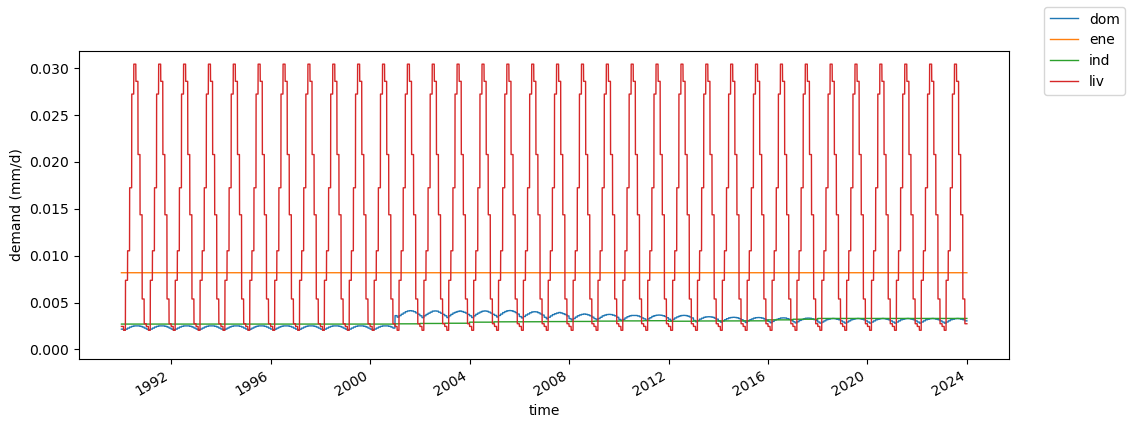

In [12]:
# load the pixel area map
pixarea = xr.open_mfdataset(f'{cfg.PATH_LISFLOOD}/iberia/maps/pixarea*.nc')['Band1'].compute()

maps = ['dom', 'ene', 'ind', 'liv']

# load maps
demand = {}
start, end = pd.to_datetime('1990-01-01'), pd.to_datetime('2023-12-31')
dates = pd.date_range(start, end, freq='D')
for use in tqdm(maps):
    
    # load dataset of demand
    da = xr.open_mfdataset(f'{cfg.PATH_LISFLOOD}/iberia/maps/{use}_*.nc').compute()
    
    # compute cachtment statistic
    df = catchment_statistics(da, masks, statistic=['mean'], weight=pixarea)[f'{use}_mean'].to_pandas()
    
    # convert dataframe to daily resolution
    daily_df = pd.DataFrame(np.nan, index=dates, columns=df.columns)
    daily_df.index.name = 'time'
    daily_df.loc[df.index] = df

    # fill NaN
    daily_df = daily_df.ffill()
    # daily_df = daily_df.interpolate(method='linear')

    # convert to DataArray
    demand[use] = xr.Dataset.from_dataframe(daily_df).to_array(dim='id', name=use)

# combine all demands in one Dataset
demand = xr.Dataset(demand)
demand = demand.rename({'id': 'GRAND_ID'})

# export demand time series
path_out = cfg.PATH_RESOPS / 'ancillary' / 'catchstats' / 'demand'
path_out.mkdir(parents=True, exist_ok=True)
for grand_id in demand.GRAND_ID.data:
    demand.sel(GRAND_ID=grand_id).to_netcdf(path_out / f'{grand_id:04}.nc')

# plot daily mean demands
fig, ax = plt.subplots(figsize=(12, 4))
for use, da in demand.items():
    da.mean('GRAND_ID').plot(ax=ax, lw=1, label=use)
ax.set(ylabel='demand (mm/d)',
       ylim=(-.001, None))
fig.legend();

***

#### Net inflow

In [13]:
path_ts = PATH_DATASETS / 'CEDEX/processed/reservoirs/timeseries'

obs_CEDEX = {}
start = datetime(1990, 1, 1)
for grand_id in tqdm(reservoirs.loc[reservoirs.SOURCE_TS == 'CEDEX'].index):
    
    # load observed data
    ID_TS = reservoirs.loc[grand_id, 'ID_TS']
    try:
        csv_file = path_ts / f'{ID_TS:0>4}.csv'
        df = pd.read_csv(csv_file, parse_dates=True, dayfirst=False, index_col=0)
        df = df.loc[start:,:]
    except:
        print(f'ERROR. File {csv_file} could not be read.')
        continue
        
    # compute net inflow
    if ('outflow' in df.columns) & ('storage' in df.columns):
        df['ΔS'] = np.nan
        df.loc[df.type == 1, 'ΔS'] = df.loc[df.type == 1, 'storage'].shift(-1).diff().values
        df.loc[df.type == 2, 'ΔS'] = df.loc[df.type == 2, 'storage'].diff().values
        df['net_inflow'] = df['ΔS'] * 1e6 / (24 * 3600) + df['outflow']
        df.loc[df.net_inflow < 0, 'net_inflow'] = 0
        
        # inflow_net[{'SNCZI': ID}]
        obs_CEDEX[grand_id] = df
    else:
        print(f'Reservoir {grand_id} does not include all time series:', df.columns)

  0%|          | 0/212 [00:00<?, ?it/s]

Reservoir 7059 does not include all time series: Index(['storage', 'type'], dtype='object')


#### Bias correction

In [14]:
inflow_bc = xr.zeros_like(inflow) * np.nan
# inflow_bc.name += '_bc'
grand_ids = set(obs_CEDEX).intersection(inflow_bc.GRAND_ID.data)
for grand_id in tqdm(grand_ids): 
    try:
        sim_bc = quantile_mapping(obs=obs_CEDEX[grand_id].net_inflow,
                                  sim=inflow.sel({'GRAND_ID': grand_id}).to_pandas())
        inflow_bc.loc[{'GRAND_ID': grand_id}] = sim_bc.values
    except Exception as e:
        print(grand_id, e)
inflow_bc = inflow_bc.dropna('GRAND_ID', how='all')

  0%|          | 0/211 [00:00<?, ?it/s]

2818 float division by zero


#### Plots comparing mass-balance-estimated, simulated and bias-corrected-simulated inflow

In [15]:
# path_plots = cfg.PATH_TS 'plots' / 'compare_inflows'
# path_sim = path_plots / 'simulation'
# path_sim.mkdir(parents=True, exist_ok=True)
# path_sim_bc = path_plots / 'bias_corrected'
# path_sim_bc.mkdir(parents=True, exist_ok=True)

# grand_ids = list(set(obs_CEDEX).intersection(inflow_bc.GRAND_ID.data))
# grand_ids.sort()
# for i, grand_id in enumerate(grand_ids):
        
#     obs = obs_CEDEX[grand_id]
    
#     # without bias correction
#     sim = inflow.sel(grand_id=grand_id).to_pandas()   
#     sim.name = 'inflow-EFAS'
#     sim.index.name = 'date'
#     compare_flows(obs.storage, obs.outflow, obs.net_inflow, sim,
#                   save=path_sim / f'{grand_id:0>4}.jpg',
#                   title='{0} - {1}'.format(grand_id, reservoirs.loc[grand_id, 'RES_NAME']))
    
#     # bias corrected
#     sim_bc = inflow_bc.sel(grand_id=grand_id).to_pandas()  
#     sim_bc.name = 'inflow-EFAS-BC'
#     sim_bc.index.name = 'date'
#     compare_flows(obs.storage, obs.outflow, obs.net_inflow, sim_bc,
#                   save=path_sim_bc / f'{grand_id:0>4}.jpg',
#                   title='{0} - {1}'.format(grand_id, reservoirs.loc[grand_id, 'RES_NAME']))

***

#### Plots by year

In [16]:
# path_plots = Path('Z:/nahaUsers/casadje/datasets/reservoirs/ResOpsES/timeseries/plots/compare_inflows/yearly/')

# # for i, (ID, df) in enumerate(obs_CEDEX.items()):
# ID = 1336 # 1125 #1089
# df = obs_CEDEX[ID].copy()

# sim_df = inflow.sel(SNCZI=ID).to_pandas()
# sim_df.index.name = 'date'
# sim_df.name = 'inflow-EFAS'

# aux = pd.concat((df, sim_df), axis=1)
# aux = aux[['storage', 'outflow', 'inflow', 'inflow-EFAS']]
# aux.dropna(axis=0, how='any', inplace=True)

# for year in aux.index.year.unique():

#     aux_y = aux.loc[aux.index.year == year]

#     fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8, 8), sharey=True)
#     vmax = aux[['inflow', 'outflow', 'inflow-EFAS']].max().max()
#     r = len(str(int(vmax)))
#     vmax = np.ceil(vmax / 10**r) * 10**r
#     vmin = 0.001
    
#     for c, x in enumerate(['inflow', 'outflow']):
#         for r, y in enumerate(['outflow', 'inflow-EFAS']):
#             if c == 1 and r == 0:
#                 continue
                
#             sct = ax[r,c].scatter(aux_y[x], aux_y[y], c=aux_y.storage, cmap='coolwarm_r', s=4, alpha=.5)
#             ax[r,c].plot([vmin, vmax], [vmin, vmax], '--k', lw=.5, zorder=0)
            
#             try:
#                 kge, alpha, beta, rho = KGE(aux_y[x], aux_y[y])
#                 ax[r,c].text(.01, .99, f'KGE={kge:.2f}', transform=ax[r,c].transAxes, ha='left', va='top')
#                 ax[r,c].text(.01, .94, f'α={alpha:.2f}', transform=ax[r,c].transAxes, ha='left', va='top')
#                 ax[r,c].text(.01, .89, f'β={beta:.2f}', transform=ax[r,c].transAxes, ha='left', va='top')
#                 ax[r,c].text(.01, .84, f'ρ={rho:.2f}', transform=ax[r,c].transAxes, ha='left', va='top')
#             except:
#                 pass
            
#             ax[r,c].set(xlim=(vmin, vmax),
#                         xscale=scale, 
#                         ylim=(vmin, vmax),
#                         yscale=scale)
#             if r == 1:
#                 ax[r,c].set_xlabel('{0} (m3/s)'.format(x))
#             if c == 0:
#                 ax[r,c].set_ylabel('{0} (m3/s)'.format(y))
#                 if r == 0:
#                     ax[r,c].set_xticklabels([])
    
#     # ecdf
#     for col, ls in zip(['inflow', 'inflow-EFAS', 'outflow'], ['--', ':', '-']):
#         ax[0,1].plot(ECDF(aux_y[col], plot=False), c='k', ls=ls, lw=1, label=col)
#     ax[0,1].set(xlabel='ECDF (-)',
#                 ylabel='flow (m3/s)',
#                 xlim=(-.02, 1.02),
#                 ylim=(vmin, vmax),
#                 yscale=scale)
#     ax[0,1].legend(frameon=False);

#     cbar_ax = fig.add_axes([0.33, 0.02, 0.33, 0.015])
#     plt.colorbar(sct, cax=cbar_ax, orientation='horizontal', label='storage (hm3)')
    
#     fig.text(0.5, .925, '{0} - {1} ({2})'.format(ID, reservoirs.loc[ID, 'RES_NAME'], year),
#              ha='center', va='top', fontsize=12);
    
#     plt.savefig(path_plots / f'{ID:0>4}_{year}.jpg', dpi=300, bbox_inches='tight')

***

## Dataset: hydrometeo attributes

Here I derive static attributes from the time series.

### EMO-1

In [17]:
# monthly aggregation (as mean daily value)
meteo_m = meteo_areal.groupby('time.month').mean()
meteo_m = meteo_m.rename({'month': 'time'})

# annual aggregation (as mean daily value)
meteo_y = meteo_areal.mean('time')
meteo_y['time'] = ['year']

# concatenate monthly and annual aggregations
meteo_ag = xr.concat((meteo_m, meteo_y), dim='time')

# organizar en un DataFrame
attr_climate = pd.DataFrame(index=meteo_ag.GRAND_ID.data)
for var, da in tqdm(meteo_ag.items()):
    # mensual
    df = da.to_pandas().transpose()
    df.columns = [f'{var}_{i:02}' if i != 'year' else f'{var}_{i}' for i in df.columns]
    # concatenar
    attr_climate = pd.concat((attr_climate, df), axis=1)
attr_climate.index.name = 'GRAND_ID'

  0%|          | 0/3 [00:00<?, ?it/s]

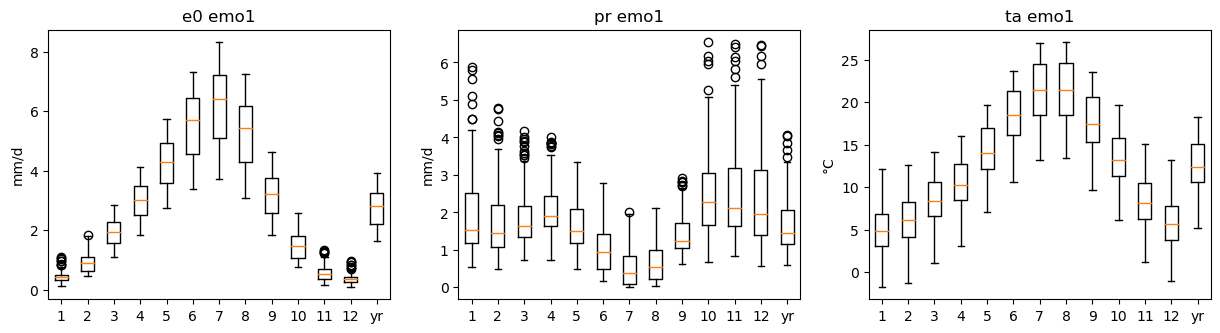

In [18]:
# box plots of monthly and annual meteorological values
ncols = len(meteo_areal)
fig, axes = plt.subplots(ncols=ncols, figsize=(5 * ncols, 3.5))

for ax, var in zip(axes, list(meteo_areal)):
    mask_var = attr_climate.columns.str.startswith(var)
    df = attr_climate.loc[:, mask_var]
    ax.boxplot(df)
    if var in ['pr_emo1', 'e0_emo1']:
        ax.set_ylabel('mm/d')
    elif var in ['ta_emo1']:
        ax.set_ylabel('°C')
    ax.set_title(' '.join(var.split('_')))
    ax.set_xticklabels([i for i in range(1, 13)] + ['yr'])

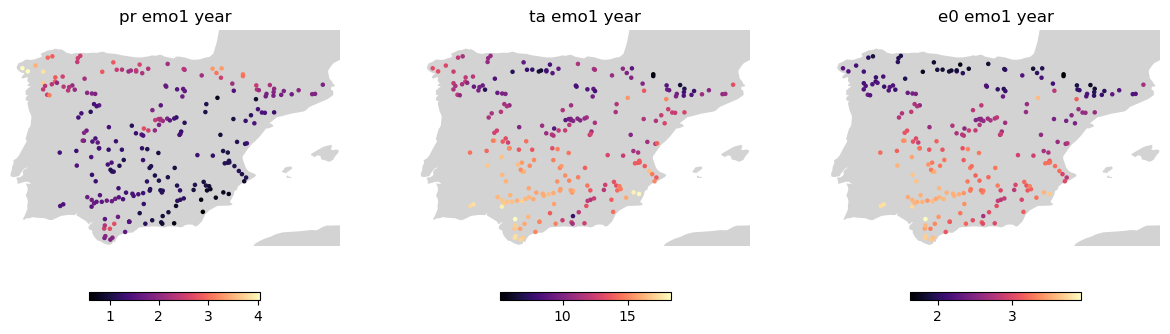

In [19]:
# maps of annual meteorological averages
plot_attributes(attr_climate[['pr_emo1_year', 'ta_emo1_year', 'e0_emo1_year']],
                reservoirs.geometry.x,
                reservoirs.geometry.y)

### EFAS inflow

<font color='red'>Add standard deviation or coefficient of variation?</font>

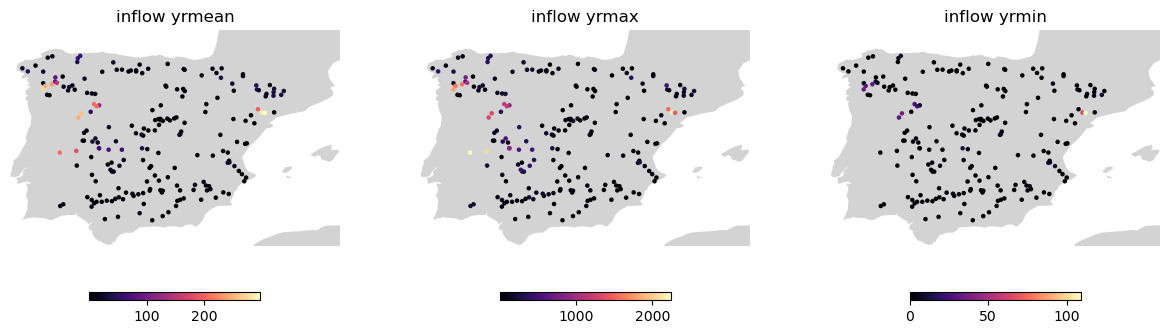

In [20]:
var = 'inflow' # 'inflow_efas5_bc'

# mean monthly discharge inflow
inflow_m = inflow_bc.groupby('time.month').mean('time').to_pandas()
inflow_m.columns = [f'{var}_{month:02}' for month in inflow_m.columns]

# annual average on minimum, mean and maximum discharge inflow
inflow_y = inflow_bc.groupby('time.year')
inflow_y = pd.DataFrame({f'{var}_yrmean': inflow_y.mean().mean('year').to_pandas(),
                      f'{var}_yrmax': inflow_y.max().mean('year').to_pandas(),
                      f'{var}_yrmin': inflow_y.min().mean('year').to_pandas()})
inflow_y.index.name = 'GRAND_ID'

# combine in a single DataFrame
attr_inflow = pd.concat((inflow_m, inflow_y), axis=1)

# plot
plot_attributes(attr_inflow[[f'{var}_yrmean', f'{var}_yrmax', f'{var}_yrmin']], reservoirs.geometry.x, reservoirs.geometry.y, ncols=5)

### Demand

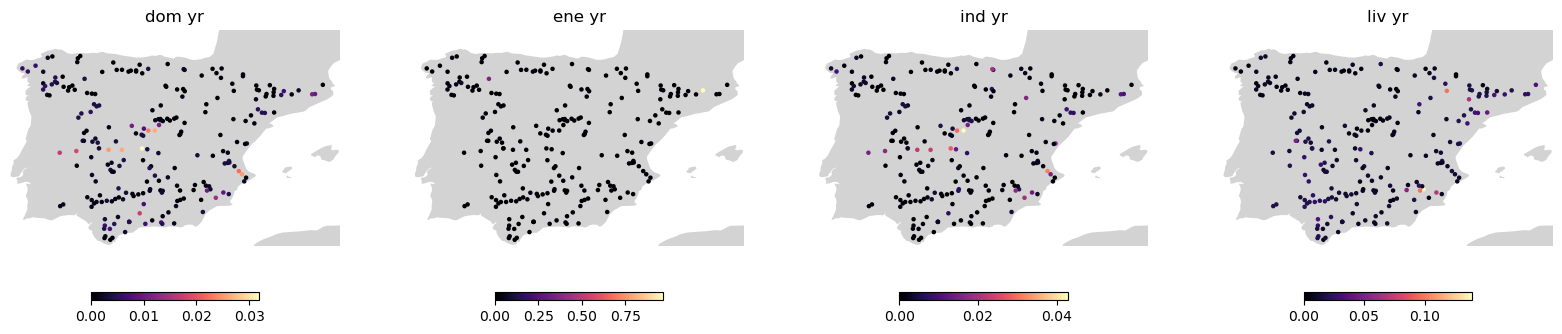

In [21]:
# # monthly means
# demand_m = demand.groupby('time.month').mean('time')

# # annual mean
# demand_y = demand.groupby('time.year').mean('time').mean('year')
# # demand_y = demand.mean('time')

# # combine in a single dataset
# demand_agg = xr.Dataset()
# for key, da in demand_m.items():
#     for month in da.month.data:
#         demand_agg[f'{key}_{month:02}'] = da.sel(month=month).drop('month')
#     demand_agg[f'{key}_yr'] = demand_y[key]

# # convert to volume
# # demand_agg = demand_agg * 1e-3 * pixarea

# # # compute statistics
# # attr_demand = catchment_statistics(demand_agg, masks, statistic=['sum'], weight=pixarea).to_pandas()

# # # rename attributes
# # attr_demand.rename(columns={col: '_'.join(col.split('_')[:-1]) for col in attr_demand if 'sum' in col}, inplace=True)

# attr_demand = demand_agg.to_pandas()

# # plot attributes
# plot_attributes(attr_demand.loc[reservoirs.index, ['dom_yr', 'ene_yr', 'ind_yr', 'liv_yr']], reservoirs.geometry.x, reservoirs.geometry.y, ncols=4)

### Export

In [22]:
# concatenate attributes
attr_hydrology = pd.concat((attr_climate, attr_inflow), axis=1)
attr_hydrology.index.name = 'GRAND_ID'

print('{0} attributes define the hydrometeorology of {1} catchments'.format(*attr_hydrology.shape[::-1]))

# exportar
attr_hydrology.to_csv(cfg.PATH_ATTRS / 'efas_hydrometeorology.csv')

106 attributes define the hydrometeorology of 234 catchments


## Dataset: Time series

Here I generate the files in the *timeseries* subfolder of the data set that will be the forcing data in the deep learning model. When possible, I will convert the variables first to volume (m3) and second to fraction of the specific reservoir capacity. In this way, all the time series used in the reservoir routine are in the same unit (adimensional), and in addition is normalized by the size of the reservoir (values from 0 to 1).

In [23]:
# Dataset of inflow
# inflow = xr.merge((inflow, inflow_bc)) # merge raw and bias-corrected EFAS inflow
inflow = xr.Dataset({'inflow': inflow_bc})

# rename coordinate
if 'time' in meteo_areal.coords:
    meteo_areal = meteo_areal.rename({'time' : 'date'})
if 'time' in meteo_point.coords:
    meteo_point = meteo_point.rename({'time' : 'date'})
if 'time' in inflow.coords:
    inflow = inflow.rename({'time' : 'date'})
    # inflow_bc = inflow_bc.rename({'time' : 'date'})
if 'time' in demand.coords:
    demand = demand.rename({'time': 'date'})

# rename variables
meteo_point = meteo_point.rename({
    'e0': 'evapo_point_emo1',
    'pr': 'precip_point_emo1'
})
meteo_areal = meteo_areal.rename({
    'e0_emo1': 'evapo_areal_emo1',
    'pr_emo1': 'precip_areal_emo1',
    'ta_emo1': 'temp_areal_emo1'
})

### Convert units

In [24]:
if cfg.NORMALIZE:
    
    area_sm = xr.DataArray.from_series(reservoirs.AREA_SKM) * 1e6 # m2
    capacity_cm = xr.DataArray.from_series(reservoirs.CAP_MCM) * 1e6 # m3
    catchment_sm = xr.DataArray.from_series(reservoirs.CATCH_SKM) * 1e6 # m2

    # Observed timeseries
    # -------------------

    for ID, ds in Obs.items():
        if 'storage' in list(ds):
            ds['storage_norm'] = ds['storage'] / reservoirs.loc[ID, 'CAP_MCM']
        if 'outflow' in list(ds):
            ds['outflow_norm'] = ds['outflow'] * 24 * 3600 / (reservoirs.loc[ID, 'CAP_MCM'] * 1e6)

    # Reservoir meterology
    # --------------------

    # convert point evaporation and precipitation from mm to fraction filled
    for var in ['evapo', 'precip']:
        meteo_point[f'{var}_point_emo1_norm'] = meteo_point[f'{var}_point_emo1'] * 1e-3 * area_sm / capacity_cm

    # Catchment meteorology
    # ---------------------

    # convert areal evaporation and precipitation from mm to fraction filled
    for var in ['evapo', 'precip']:
        meteo_areal[f'{var}_areal_emo1_norm'] = meteo_areal[f'{var}_areal_emo1'] * catchment_sm * 1e-3 / capacity_cm                                                         

    # Simulated inflow
    # ----------------

    # convert m3/s to fraction filled
    for var, da in inflow.items():
        inflow[f'{var}_norm'] = da * 24 * 3600 / capacity_cm

    # Demands
    # -------

    # convert mm to franction filled
    for var, da in demand.items():
        demand[f'{var}_norm'] = da * 1e-3 * area_sm / capacity_cm

### Export

In [27]:
# output directory
path_ts_csv = cfg.PATH_TS / 'csv'
path_ts_csv.mkdir(parents=True, exist_ok=True)
path_ts_nc = cfg.PATH_TS / 'netcdf'
path_ts_nc.mkdir(parents=True, exist_ok=True)

# for ID in tqdm(reservoirs.index, desc='reservoirs'):
for grand_id in tqdm(inflow_bc.GRAND_ID.data, desc='reservoirs'):

    # observed storage (and outflow)
    obs_id = Obs[grand_id].drop(['GRAND_ID'])
    
    # simulated inflow
    inflow_id = inflow.sel(GRAND_ID=grand_id).drop(['GRAND_ID', 'lat', 'lon', 'crs'])

    # reservoir meteo
    meteo_point_id = meteo_point.sel(GRAND_ID=grand_id).drop(['GRAND_ID', 'crs', 'lat', 'lon'])#, 'lat', 'lon', 'crs'])
    # emo_res.name = 'evaporation_emo1'

    # catchment meteorological
    meteo_areal_id = meteo_areal.sel(GRAND_ID=grand_id).drop(['GRAND_ID'])

    # demands
    demand_id = demand.sel(GRAND_ID=grand_id).drop(['GRAND_ID'])

    # combine time series
    ds = xr.merge((obs_id, inflow_id, meteo_point_id, meteo_areal_id, demand_id))#, compat='override')    

    # create time series of temporal attributes
    ds['year'] = xr.DataArray(dates.year.values, dims='date', name='year')
    ds['month'] = xr.DataArray(dates.month.values, dims='date', name='month')
    ds['weekofyear'] = xr.DataArray(dates.isocalendar().week.values, dims='date', name='weekofyear')
    ds['dayofyear'] = xr.DataArray(dates.dayofyear.values, dims='date', name='dayofyear')
    ds['dayofweek'] = xr.DataArray(dates.dayofweek.values, dims='date', name='dayofweek')

    # find period with observations
    df = ds.to_pandas()
    df.drop(columns=['lat', 'lon'], errors='ignore', inplace=True)
    start_id = df.storage.first_valid_index()
    end_id = min(df.storage.last_valid_index(), df.inflow.last_valid_index())
    if 'outflow' in df.columns:
        start_id = max(start_id, df.outflow.first_valid_index())
        end_id = min(end_id, df.outflow.last_valid_index())
        
    if (end_id - start_id).days >= cfg.MIN_YEARS * 365:
        print(grand_id, start_id.date(), end_id.date(), sep='\t')
    
        # export CSV
        # ..........
        df.loc[start_id:end_id, :].to_csv(path_ts_csv / f'{grand_id}.csv')

        # export NetCDF
        # .............
        ds.sel(date=slice(start_id, end_id)).to_netcdf(path_ts_nc / f'{grand_id}.nc')
    else:
        print(grand_id, start_id.date(), end_id.date(), f'Observed period shorter than {cfg.MIN_YEARS} years', sep='\t')
        continue

reservoirs:   0%|          | 0/210 [00:00<?, ?it/s]

2873	1991-06-01	2020-10-01
2885	1991-12-01	2020-10-01
2702	1990-01-01	2020-09-30
2832	1990-01-01	2020-09-30
2709	1996-02-01	2020-09-30
2868	1997-03-01	2020-10-01
2763	1992-04-29	2020-09-30
2699	1990-01-01	2020-09-30
3499	1990-01-01	2020-09-30
3489	1990-01-01	2020-09-30
3486	1990-01-01	2020-09-30
2897	1993-02-01	2020-10-01
2656	1990-01-01	2015-10-01
2830	1990-01-01	2020-09-30
2766	1990-01-01	2020-09-30
2678	1990-01-01	2020-09-30
2864	1990-01-01	2020-10-01
2839	1990-01-01	2020-09-30
2706	1996-02-01	2020-09-30
2870	1990-01-01	2020-10-01
2762	1990-01-01	2020-09-30
2850	1990-01-01	2020-10-01
2835	1992-05-02	2020-10-01
2805	1990-01-01	2020-09-30
2743	1990-01-01	2020-09-30
2866	1990-01-01	2019-09-30
2688	1990-01-01	2020-09-30
3507	1990-01-01	2020-09-30
2810	1996-10-01	2020-09-30
2796	2019-10-01	2020-09-30	Observed period shorter than 4 years
2744	1990-01-01	2020-09-30
2794	1990-01-01	2020-09-30
2764	1990-01-01	2020-09-30
2745	1990-01-01	2020-09-30
2694	1990-01-01	2020-09-30
2723	1990-01-01	20